# Magnetic Processing - Workflow

- This script goes through the steps necesary to process magnetic data acquired with the [Geometrics G-858GAP](https://www.geometrics.com/wp-content/uploads/2018/10/G-858GAP_Manual_revB1.pdf) Cesium Vapor Magnetometer. Those steps include
    - Import and plot data
    - Clean data (outliers, zeros...)
    - Filter data, i.e. remove low (and possibly high) frequency trends to focus on the bandwidth of interest.
    - Export georeferenced raster image.

- Using QGIS one can then import the georeferenced raster image and overlay it with a orthophoto (or topography map) from https://maps.zh.ch for reporting.
- For any questions do not hesitate to contact the person in charge of the field work method: Jonas Müller, jonas.mueller@erdw.ethz.ch

June 2024 - Jonas Müller

In [88]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# this file needs to be in the same folder as the notebook or alternatively in the python path
import utils

In [89]:
# define acquisition parameters
sensor1_is_left = False

dLine = 0.5  # mag.p['dLine']
dSensors = 0.25  # mag.p['dSensors']
dMark = 5  # mag.p['dMark']

In [90]:
# working directory
base = Path('/Users/jonasmuller/polybox/Shared/field course 2024')

#folderIn = base / 'archive/field course 2023/data'
folderIn = base / 'data'
folderOut = base / 'export'

# list available files
for p in folderIn.glob('*.dat'):
    print(p.name)

dataset2.dat
dataset3.dat
dataset1.dat


In [91]:
# set data Path
fileName = 'dataset3'
pathIn = folderIn / f'{fileName}.dat'

In [92]:
# load data
df = pd.read_csv(pathIn, sep='\s+')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yq/h12yd5pn0mq_5841165vwrd40000gn/T/ipykernel_3622/2591457449.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(pathIn, sep='\s+')


In [93]:
# convert dataframe structure
mag = utils.Magnetics(df)
mag.df

Sensor spacing: 0.2500 m


,time,line,mark,BL,BR,x,y,direction
0,2010-11-02 10:34:35.100,0,0,48221.859,48208.753,0.0,0.019,1.0
1,2010-11-02 10:34:35.200,0,0,48229.620,48210.285,0.0,0.057,1.0
2,2010-11-02 10:34:35.300,0,0,48233.334,48212.050,0.0,0.095,1.0
3,2010-11-02 10:34:35.400,0,0,48233.921,48214.669,0.0,0.134,1.0
4,2010-11-02 10:34:35.500,0,0,48231.813,48216.935,0.0,0.172,1.0
...,...,...,...,...,...,...,...,...
46534,2010-11-02 14:22:54.300,60,9,48232.659,48231.234,30.0,49.712,1.0
46535,2010-11-02 14:22:54.400,60,9,48232.344,48230.323,30.0,49.776,1.0
46536,2010-11-02 14:22:54.500,60,9,48231.638,48229.579,30.0,49.840,1.0
46537,2010-11-02 14:22:54.600,60,9,48230.537,48229.394,30.0,49.904,1.0


In [94]:
# We use the convention that field BL is the left sensor and BR is the right sensor (from the perspective of the person holding the sensors). If this is different for your setup swap fields here.
if not sensor1_is_left:
    mag.df = mag.df.rename(columns={'BL': 'BR', 'BR': 'BL'})

Number of zeros: 0


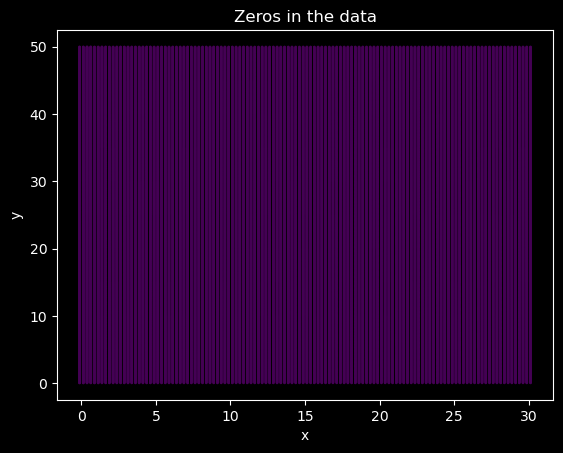

In [95]:
# plot zeros
d = mag.stackFields()
z = d[['B']]==0
print(f'Number of zeros: {z.sum().values[0]}')

a = d.plot.scatter('x','y',c=z['B'],s=1)
plt.title('Zeros in the data');

In [96]:
# replace zeros
b = ['BL','BR']
mag.df[b] = mag.df[b].replace(0,np.nan)
mag.df[b] = mag.df[b].interpolate(method='linear')

In [97]:
# preprocess data
mag.remove_median_field()
mag.time2sec();

Mean field: 48227.78 nT


## Show data

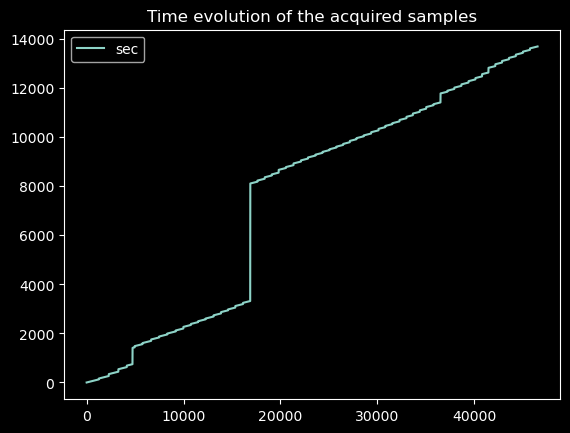

In [98]:
# plot acquired samples over time
plt.figure()
a = mag.df['sec'].sort_values().reset_index(drop=True).plot(legend=True)
plt.title('Time evolution of the acquired samples');

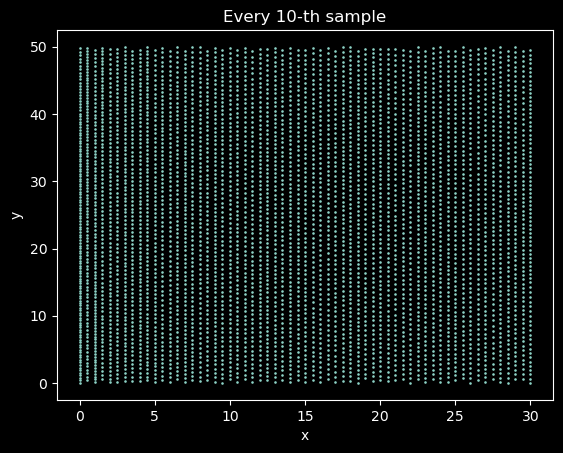

In [99]:
# plot every nth-sample
nSubSamples = 10
a = mag.df[::nSubSamples].plot.scatter(x='x', y='y', s=3, alpha=1, marker='.')
plt.title(f'Every {nSubSamples}-th sample');

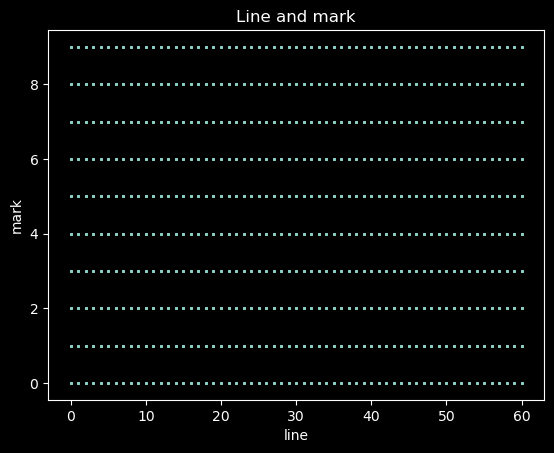

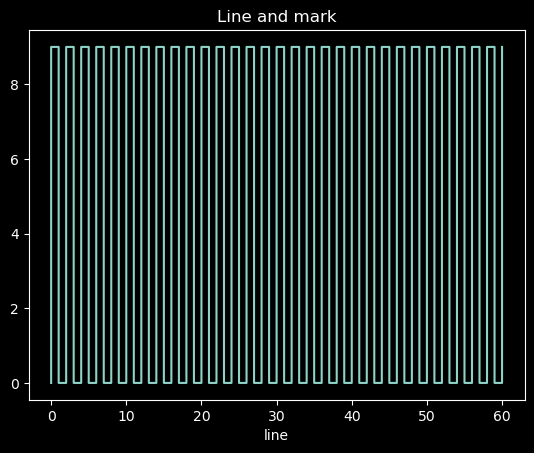

In [100]:
# plot line and mark
a = mag.df.plot.scatter(x='line', y='mark', s=2, alpha=0.3, marker='.')
plt.title('Line and mark')
a = mag.df.plot.line(x='line', y='mark',legend=False)
plt.title('Line and mark');

Field quantiles 5%	 [-10.66    8.598]


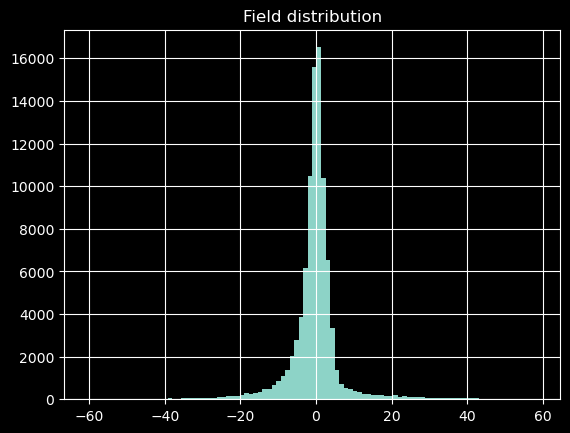

In [101]:
# distribution
q = 0.05
fieldQuantile = mag.quantile(q)

r = fieldQuantile + np.array([-1, 1])*50
d = mag.df[['BL', 'BR']].stack()

print(f'Field quantiles {q * 100:.0f}%\t {fieldQuantile}')
plt.figure()
a = d.hist(bins=100, range=r)
plt.title(f'Field distribution');

Number of outliers: 2629 (5.6%)


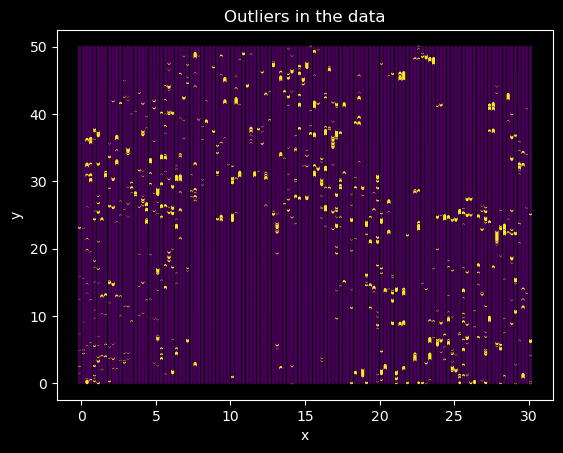

In [102]:
# remove outliers
nWindow = 30

b = ['BL', 'BR']
dfMed = mag.df.copy(deep=True)
dfMed[b] = dfMed[b].rolling(window=nWindow).median()

outlier = mag.df[b].abs() > 20*dfMed[b].abs()

# replace outliers
#mag.df[outlier] = np.nan
#mag.df[outlier] = dfMed[outlier]

# count outliers
n = outlier.sum().sum()
print(f'Number of outliers: {n} ({n/len(mag.df)*100:.1f}%)')

# plot outliers
dfMedPlot = dfMed.copy(deep=True)
dfMedPlot[b] = outlier
d = mag.stackFields(dfMedPlot)
a = d.plot.scatter('x','y',c=d['B'],s=1)
plt.title('Outliers in the data');

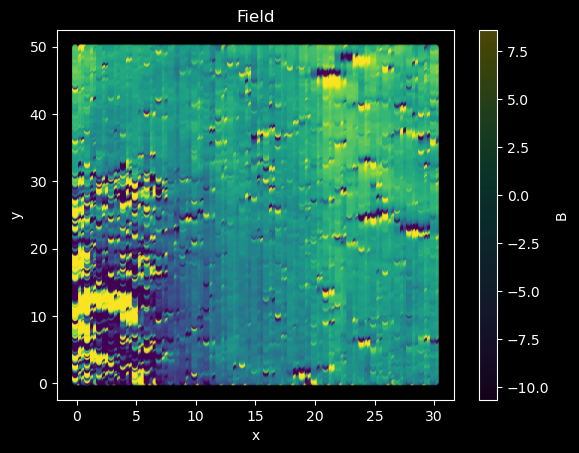

In [103]:
# plot field
d = mag.stackFields()

a = d.plot.scatter(
    x='x',
    y='y',
    c='B',
    s=10,
    alpha=0.3,
    marker='o',
    vmin=fieldQuantile[0],
    vmax=fieldQuantile[1],
    cmap='viridis')
plt.title('Field');

In [104]:
mag.estimate_line_spacing()

Estimated line spacing: 0.50 m


In [105]:
mag.estimate_mark_spacing()

Estimated mark spacing: 5.00 m


In [106]:
# get direction for bidirectional survey
mag.get_direction()
# a = mag.df.plot.line(y='direction')
# a = mag.df.plot.line(x='line', y='mark')

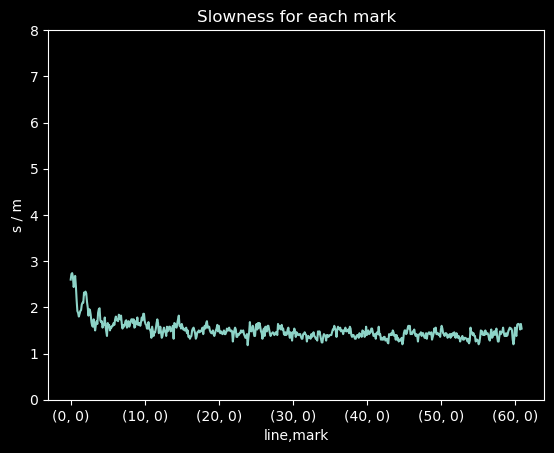

In [107]:
# get slowness
mag.df.sort_values(by=['line', 'mark'], inplace=True)
mag.df.reset_index(drop=True, inplace=True)

v = mag.get_mark_times()
v = v/dMark

plt.figure()
a = v.plot()
# a.set_ylim(0, 10)
a.set_ylabel('s / m');
a.set_ylim(0, 8)
plt.title('Slowness for each mark');

# Recalculate x,y from line,mark

This section is only necessary if there are corrections to be made to the lines and marks such that the x,y do then no longer correspond to them.
In this case you can correct the marks,lines then recalculate x,y. They will be added as x2,y2.
If you want to use them for further processing you need to assign x,y = x2,y2.

In [108]:
# recalculate x
mag.line2x(dLine)

# compare x and x2
# d = mag.df[['x', 'x2']]
# d = d['x2'] - d['x']

# plt.figure()
# a = d.plot()

In [109]:
# recalculate y
mag.interpolate_marks()
mag.mark2y(dMark);

In [110]:
# compare y and y2
mag.df.sort_values(by=['x', 'y'], inplace=True)
mag.df.reset_index(drop=True, inplace=True)

# d = mag.df[['y', 'y2']]
# a = d.plot()

# Interpolate data to regular grid

Here we interpolate the y-axis onto a regular grid.

In [111]:
# query grid
d = mag.df[['x', 'y']]
m1 = d.min().apply(np.floor)
m2 = d.max().apply(np.ceil)
r = [m1['y'], m2['y']]

nSamplesPerLine = d.groupby('x')['y'].count()
ny = int( nSamplesPerLine.quantile(0.90).round(-1) )
ny

840

In [112]:
# define interpolation grid
ny = 1000
y = pd.DataFrame({'y': np.linspace(*r, ny)})
print(f'Interpolation grid: {r[0]} to {r[1]} with {ny} samples')

Interpolation grid: 0.0 to 50.0 with 1000 samples


In [113]:
# interpolate
d = mag.df[['x', 'y', 'BL', 'BR','direction']].copy(deep=True)
# d.groupby('x')
d['int'] = 0


def interp(df):
    # add interpolation points
    y['BL'] = np.interp(y['y'],df['y'],df['BL'])
    y['BR'] = np.interp(y['y'],df['y'],df['BR'])
    y['direction'] = df['direction'].unique().item()

    return y.copy(deep=True)

d = d.groupby('x').apply(interp, include_groups=False)
d = d.reset_index().drop(columns='level_1')

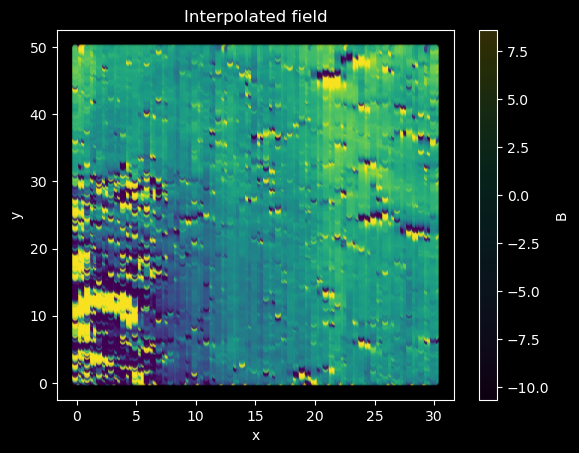

In [114]:
# plot interpolated field
ds = mag.stackFields(d)
a = ds.plot.scatter(
    x='x',
    y='y', 
    c='B', 
    s=10, 
    alpha=0.2, 
    marker='o',
    vmin=fieldQuantile[0],
    vmax=fieldQuantile[1])
plt.title('Interpolated field');

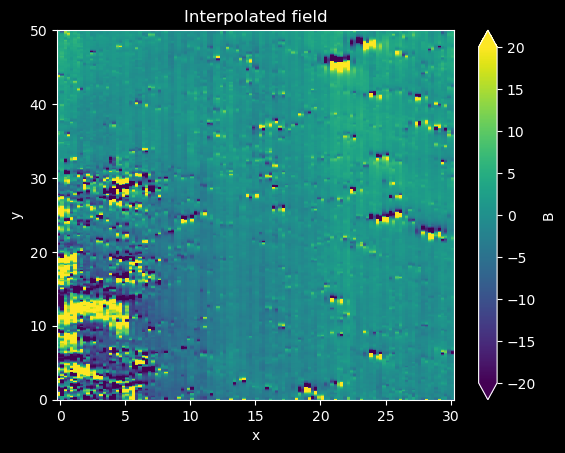

In [115]:
# plot field as an image
da = ds.set_index(['x', 'y']).squeeze().to_xarray()

m = 20
plt.figure()
a = da.plot.imshow(
    x='x',
    y='y',
    vmin=-m,
    vmax=m)
plt.title('Interpolated field');

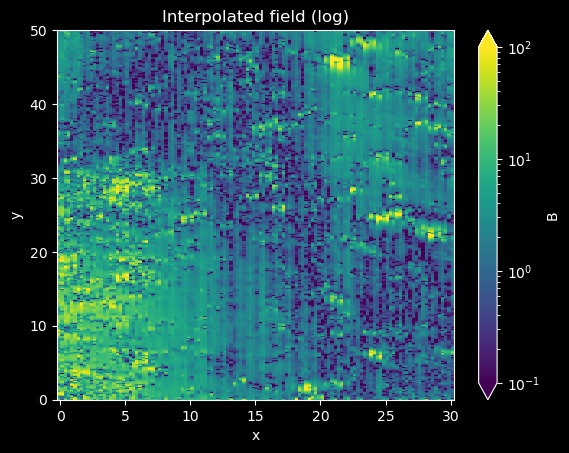

In [116]:
# logplot to see all scales
dlog = np.abs(da)
plt.figure()
a = dlog.plot.imshow(
    x='x',
    y='y',
    norm=LogNorm(vmin=0.1, vmax=100),
)
plt.title('Interpolated field (log)');

# Apply filters

In this chapter we try to filter out the static Magnetic field. In a differential measurement this would already have been removed by taking the difference of two vertically displaced sensors. Another way of doing this would be to have a stationary base station. The advantage of using the field of two horizontally displaced sensors is however the increased resolution (we can cover two lines at once).

## Rolling median
Here we calculate the median for a rolling window along the lines. This method is most robust against remaining outliers and recommended as a first try.

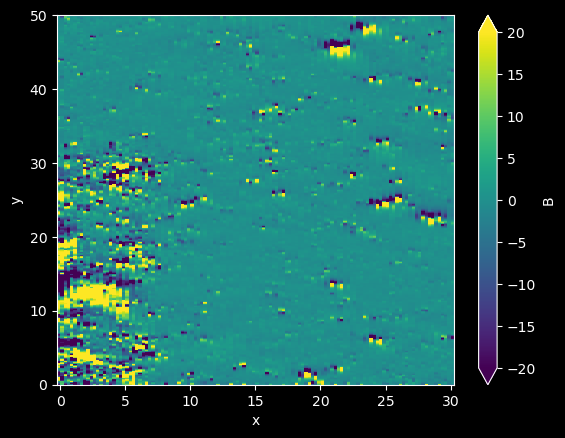

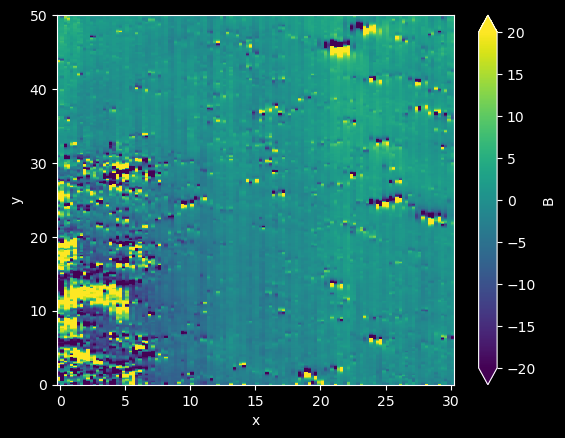

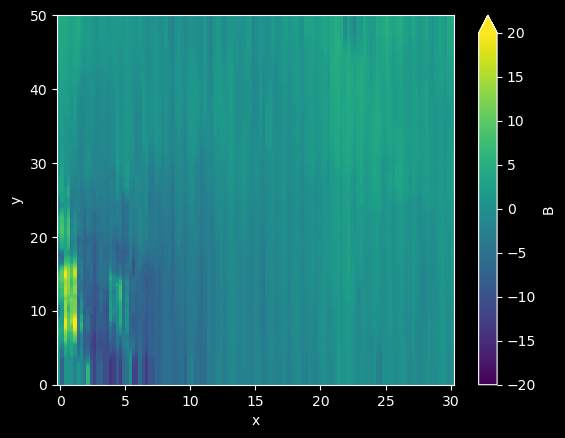

In [117]:
dmed = da.copy(deep=True)
nWindow = 200

# pad field
med = dmed.pad(y=(nWindow,nWindow), mode='median',stat_length=nWindow/2)

# filter
med = med.rolling(y=nWindow, center=True).median()

# remove padding
med = med.drop_duplicates('y').dropna('y')

dmed = dmed - med

kwargs = dict(x='x',y='y',vmin=-m,vmax=m,interpolation='nearest')

# plot filtered field
plt.figure()
a = dmed.plot.imshow(**kwargs)

# plot original field
plt.figure()
a = da.plot.imshow(**kwargs)

# plot filtered field here, i.e. the estimate of the background
# field that a base station would have measured
plt.figure()
a = med.plot.imshow(**kwargs)

# Export results for QGIS

Gridding data onto Swiss Coordinates

Using the "Mapped Survey" mode during acquisition the acquired data has
been distributed on the defined survey grid. We want to transform those
"local" coordinates to the respective Swiss cooridnates to enable correct
georeferencing of the data.

Define corner points of survey grid according to the following convention:

### indices
- 'x0_y0' -> lower left corner / start point first line
- 'x1_y0' -> lower right corner / start point last  line
- 'x1_y1' -> upper right corner / end point last  line
- 'x0_y1' -> upper left corner / end point first line

### columns coordinates
X Coordinates of the corner points of the measured area --> Easting
Y Coordinates of the corner points of the measured area --> Northing

In [118]:
# dataset properties
mag.p

{'dLine': np.float64(0.5),
 'dMark': np.float64(5.0),
 'dSensors': 0.25,
 'median_field': np.float64(48227.777),
 'start_time': Timestamp('2010-11-02 10:34:35.100000')}

In [119]:
# select dataArray
#d = da.copy(deep=True)
#d = dim.copy(deep=True)
d = dmed.copy(deep=True)

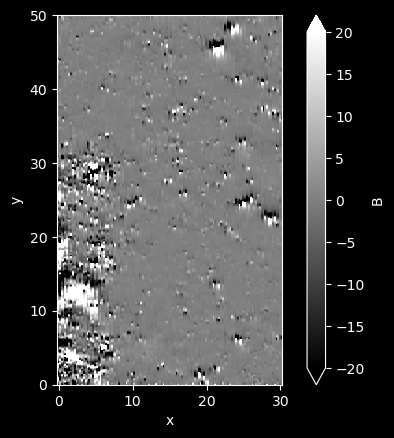

In [120]:
# plot final field
plt.figure()
a = d.plot.imshow(
    x='x',
    y='y',
    vmin=-m,
    vmax=m,
    cmap='gray')

# set equal axis for report
plt.gca().set_aspect('equal')
plt.savefig(folderOut / f'testPlot.png', dpi=300)

In [121]:
# sensor shift
d['x'] = d['x'] + dSensors/2
d

<xarray.DataArray 'B' (x: 122, y: 1000)> Size: 976kB
array([[-19.9227639 , -18.67095661, -16.28327256, ...,   0.06308713,
         -0.21757965,  -0.38875941],
       [  1.18817676,   7.52974093,  12.7399398 , ..., -27.39863717,
        -40.17491933, -47.45076682],
       [-29.84690833, -28.02318849, -23.83414792, ...,   9.92316342,
          9.75178816,   9.58740182],
       ...,
       [ -0.66483888,  -0.30215387,   0.90398184, ...,  -3.84179489,
         -3.65827804,  -3.61042785],
       [ -2.92848626,  -3.17345123,  -3.75272376, ...,  -2.14697307,
         -2.17031241,  -2.17482493],
       [ -6.29417943,  -4.97394719,  -1.54151468, ...,  -1.50145918,
         -2.34165538,  -2.64399372]])
Coordinates:
  * y        (y) float64 8kB 0.0 0.05005 0.1001 0.1502 ... 49.85 49.9 49.95 50.0
  * x        (x) float64 976B 0.0 0.25 0.5 0.75 1.0 ... 29.5 29.75 30.0 30.25

In [122]:
# import coordinates from GNSS measurements
p = folderIn / 'processing/magneticProcessing/dat/PointsField_20230613.1.csv'

if p.is_file():
    coords = pd.read_csv(p)
    coords = coords.sort_values(by='NR')
    coords
else:
    print('No coordinates loaded. Check path.')

No coordinates loaded. Check path.


In [123]:
# example corrdinates, need to be replaced by GNSS measurements
tCo = pd.DataFrame(
    {'E': np.array([2697187, 2697235,2697265,2697226]),
     'N': np.array([1237977, 1237945,1238003,1238029])},
    index=['bottom_left','bottom_right','top_right','top_left'])
tCo

,E,N
bottom_left,2697187,1237977
bottom_right,2697235,1237945
top_right,2697265,1238003
top_left,2697226,1238029


shear angle = 86.82°
rotation angle = -33.69°


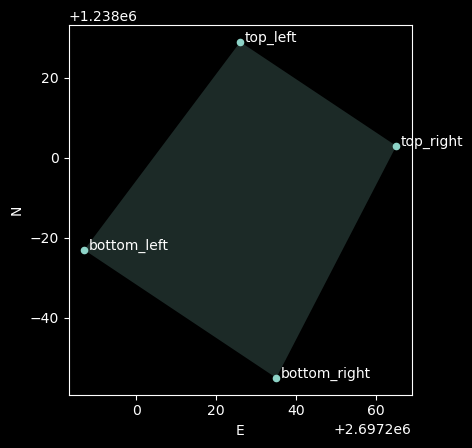

In [124]:
# plot coordinates
fig, ax = plt.subplots()
ax.fill(tCo['E'], tCo['N'], alpha=0.2)
tCo.plot.scatter(x='E', y='N',ax=ax)
ax.set_aspect('equal')

for idx, row in tCo.iterrows():
    plt.text(row['E']+1, row['N'], idx)

# axis vectors
vx = tCo.loc['bottom_right'] - tCo.loc['bottom_left']
vy = tCo.loc['top_left'] - tCo.loc['bottom_left']

# calculate shear between y-axis and x-axis
shear_angle = np.acos(np.sum(vx*vy)/(np.linalg.norm(vx)*np.linalg.norm(vy)))
print(f'shear angle = {np.degrees(shear_angle):.2f}°')

# calculate angle between origin and x-axis
rotation_angle = np.arctan2(vx['N'], vx['E'])
print(f'rotation angle = {np.degrees(rotation_angle):.2f}°')

In [125]:
distance_y = np.linalg.norm(tCo.loc['bottom_left']-tCo.loc['top_left'])
distance_x = np.linalg.norm(tCo.loc['bottom_left']-tCo.loc['bottom_right'])

print(f'coordinate distance x = {distance_y:.2f}m')
print(f'coordinate distance y = {distance_x:.2f}m')

coordinate distance x = 65.00m
coordinate distance y = 57.69m


## transformations
Below you can chose how you want to transfrom your data to the measured coordinates.
- If you have OpenCV installed you can do a perspective transformation (otherwise just comment this block out). This is very fast (GPU) and can map any four poins to any other 4 points.
- As an alternative you can do an affine transformation which applies a rotation, shear and translation. This only needs scipy but is rather slow (CPU).
### perspective transformation

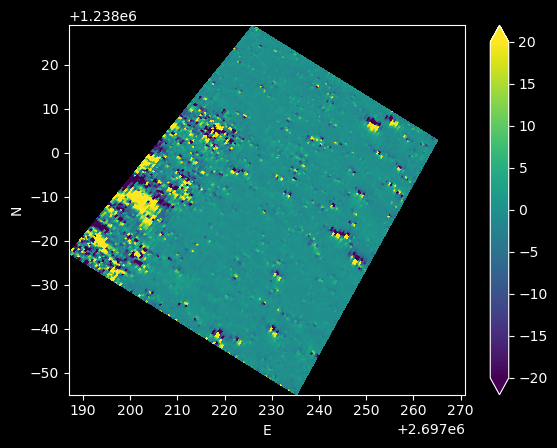

In [126]:
import cv2

c = utils.coordinates2image(d,tCo)

# calculate perspective transformation
Mperspective = cv2.getPerspectiveTransform(c['input_pts'],c['output_pts'])

# apply perspective transformation
dpersp = utils.transform_perspective(d, Mperspective, c['coordsOut'])

plt.figure()
dpersp.plot.imshow(vmin=-20,vmax=20)

### affine transform

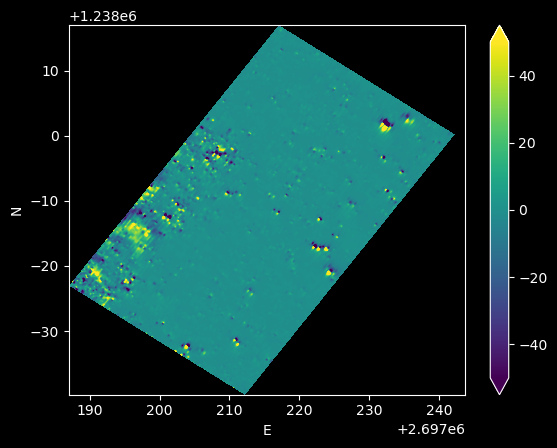

In [127]:
# default values
Maffine = utils.get_affine_matrix(
    rotation_angle, 
    shear_angle, 
    tCo.loc['bottom_left'].to_numpy()
    )

daff = utils.transform_affine(d, Maffine, resolution=3000)

m = 50
plt.figure()
a = daff.plot.imshow(vmin=-m,vmax=m)

# export data

In [128]:
# chose export data
#dexport = daff
dexport = dpersp

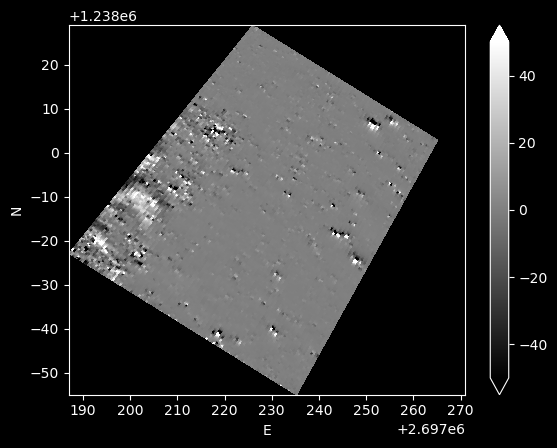

In [129]:
plt.figure()
a = dexport.plot.imshow(vmin=-m,vmax=m,cmap='gray')

In [130]:
# use the following naming convention
site = 'Oetwil'
method = 'MAG'
date = 'FC2024' # Date or fieldcourse year
dataset = 'Test' # Dataset, e.g. "Group X" or "merged"
coordRef = 'LV95' # Coordinate Reference system "LV03" (6-digit coordinates) or "LV95" (7-digit coordnates)
fileNameExport = f'{site}_{method}_{date}_{dataset}_{coordRef}'

In [131]:
# Create a georefferenced image of the final data.
utils.write_esri(dexport, folderOut / fileNameExport)
#tCo.to_csv(folderOut / 'coordinates.csv')

Griddata written to: 
/Users/jonasmuller/polybox/Shared/field course 2024/export/Oetwil_MAG_FC2024_Test_LV95.grd
